# Spooky author identification

I'm going to load the train data, consisting of text extracts from novels written by 3 different authors (Edgar Allan Poe, HP. Lovecraft and Mary Shelley), identified by author's name.
The idea is to train a model (using Natural Language Processing methods) to recognize the authors' styles and apply the model to the test data (unidentified author names).

## Import and read

In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from nltk import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

#to plot inside the document
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("spooky_train.zip", compression="zip")
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
train.describe()

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id23641,Of this sad change he seemed by no means unawa...,EAP
freq,1,1,7900


## Tokenizing

To be able to study the pieces of text, I'll break them down (tokenize) by words. I'll also break them down by sentences to see if we only have sentence-sized extracts or if some are multiple-sentenced.

_The first thing I need to do is instantiate the columns I'll be using to store the information, and change their dtype to object (otherwise, Pandas returns an error)._

In [6]:
train['tokens'] = None
train['sentences'] = None
train['nb_tokens'] = None
train['nb_sentences'] = None
train[['tokens', 'sentences']] = train[['tokens', 'sentences']].astype('object')

In [109]:
for i, row in train.iterrows():
    train.loc[i, 'tokens'] = TextBlob(row['text'].lower()).words
    train.loc[i, 'nb_tokens'] = len(train.loc[i, 'tokens'])
    train.loc[i, 'sentences'] = TextBlob(row['text']).sentences
    train.loc[i, 'nb_sentences'] = len(train.loc[i, 'sentences'])

#### Distribution, average words and sentences count

In [10]:
grouped = train.groupby('author')
toks = grouped[['nb_tokens', 'nb_sentences']].aggregate([np.sum, np.mean, np.std])
toks['nb_extract'] = grouped['nb_tokens'].aggregate('count')

ValueError: no results

In [ ]:
toks

In [ ]:
fig=plt.figure()
ax=fig.add_subplot(1,2,1)
toks[('nb_extract','')].plot(kind='bar', ax=ax)
ax.set_title("Number of extracts \nper author")
ax.xaxis.label.set_visible(False)

ax=fig.add_subplot(2,2,2)
toks[('nb_tokens','mean')].plot(kind='bar', ax=ax)
ax.set_title("Mean number \nof words per author")
ax.xaxis.label.set_visible(False)

ax=fig.add_subplot(2,2,4)
toks[('nb_sentences','mean')].plot(kind='bar', ax=ax)
ax.set_title("Mean number \nof sentences per author")
ax.xaxis.label.set_visible(False)

fig.tight_layout()

We can observe that the extracts are not entirely equally distributed (Poe has about 2000 more extracts than Lovecraft and Shelley).

On the contrary, Poe uses the least amount of words in his extracts (on average), while Shelley and Lovecraft have the same average.

For all three of them, extracts are most of times 1 sentence long, but Poe's and Lovecraft's tend to have been been cut into longer chunks a little more often than Shelley's.

## Stopwords

Remove parasitic words ("the", "and", etc.) from tokens to avoid being flooded with them in analysis.

In [11]:
train['useful'] = None
train['useful'] = train['useful'].astype('object')

In [93]:
stop_words = stopwords.words('english')
stop_words.append('one')
for i, row in train.iterrows():
    train.loc[i, 'useful'] = [x for x in row['tokens'] if x not in stop_words]

## Part of Speech and Lemmatizing

I need to tag each word in the sentences to know what part of speech they are (verb, subject, adverb, etc.)

In [94]:
train['tags'] = None
train['tags'] = train['tags'].astype('object')
for i, row in train.iterrows():
    train.loc[i, 'tags'] = pos_tag(row['useful'])

Unhappily, lemmatizing does not function with the same format of tags as the ones generated by pos_tag. I need to make a function to transform the tags to something that can be lemmatized.

In [95]:
def translate_tag_pos(tuple):
    if tuple[1].startswith('N'):
        new_tuple = (tuple[0], 'n')
    else:
        if tuple[1].startswith('V'):
            new_tuple = (tuple[0], 'v')
        else:
            if tuple[1].startswith('R'):
                new_tuple = (tuple[0], 'r')
            else:
                if tuple[1].startswith('J'):
                    new_tuple = (tuple[0], 'a')
                else:
                    return None
    return new_tuple

def lemmatize_with_new_tags(tags):
    lemmas = []
    for t in tags:
        new_tag = translate_tag_pos(t)
        if new_tag is None:
            lemmas.append(t[0])
        else:
            lemmas.append(wordnet_lemmatizer.lemmatize(new_tag[0], pos=new_tag[1]))
    return lemmas

Lemmatizing is grouping words by their root, so that plural occurences of a word are not separated from the singular ones, or conjugated verbs spread out. This allows more consistency in understanding texts.

In [96]:
wordnet_lemmatizer = WordNetLemmatizer()

train['lemma'] = None
for i, row in train.iterrows():
    lemmas = lemmatize_with_new_tags(row['tags'])
    train.loc[i, 'lemma'] = lemmas

## Wordclouds

I'll create a wordcloud image for each author. For this, I'll split the texts by author, generate a mask with images I've downloaded, and plot the wordcloud on those masks.

In [97]:
from wordcloud import WordCloud
from PIL import Image
from scipy.misc import imread


EAP = [item for sublist in train[train.author=="EAP"]['lemma'].values for item in sublist] 
HPL = [item for sublist in train[train.author=="HPL"]['lemma'].values for item in sublist] 
MWS = [item for sublist in train[train.author=="MWS"]['lemma'].values for item in sublist] 



In [104]:
poe_mask = np.array(Image.open("poe.jpg"))
lovecraft_mask = np.array(Image.open("cthulhu.jpg"))
shelley_mask = np.array(Image.open("frankenstein.jpg"))


In [105]:
masks = [
    {'title':'Edgar Allan Poe (a portrait)', 'save_name': "poe_wc.png", 'mask': poe_mask, 'text': ' '.join(EAP)},
    {'title':'HP Lovecraft (Cthulhu)', 'save_name': "cthulhu_wc.png", 'mask': lovecraft_mask, 'text': ' '.join(HPL)},
    {'title':'Mary Shelley (Frankenstein)', 'save_name': "frankenstein_wc.png", 'mask': shelley_mask, 'text': ' '.join(MWS)}
]

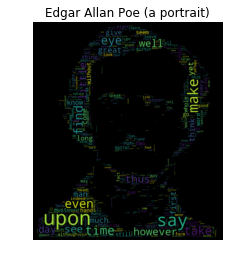

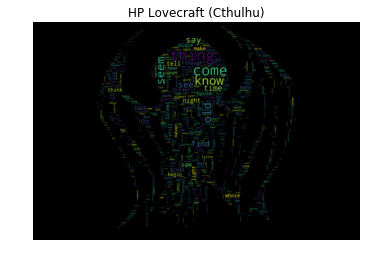

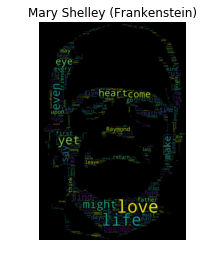

In [106]:
for m in masks:
    wc = WordCloud(background_color="black", max_words=2000, mask=m['mask'])
    # generate word cloud
    wc.generate(m['text'])

    # store to file
    wc.to_file(m['save_name'])

    # show
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(m['title'])
    plt.figure()
    plt.show()

We can see with these wordclouds that their semantic space are quite different.

I'll now take this to my advantage and create a table of their vocabulary frequencies.

## Word frequency

In [108]:
hpl_freq = FreqDist(HPL)
hpl_freq

FreqDist({'It': 319,
          'never': 187,
          'occur': 27,
          'fumble': 10,
          'might': 170,
          'mere': 14,
          'mistake': 13,
          'Finding': 1,
          'nothing': 77,
          'else': 27,
          'even': 221,
          'gold': 27,
          'Superintendent': 5,
          'abandon': 17,
          'attempt': 20,
          'perplexed': 4,
          'look': 203,
          'occasionally': 9,
          'steal': 14,
          'countenance': 4,
          'sits': 2,
          'think': 203,
          'desk': 4,
          'Herbert': 14,
          'West': 105,
          'need': 39,
          'fresh': 43,
          'body': 97,
          'life': 133,
          'work': 76,
          'reanimation': 10,
          'dead': 82,
          'The': 601,
          'farm': 4,
          'like': 277,
          'ground': 52,
          'extend': 9,
          'back': 131,
          'deeply': 17,
          'hill': 89,
          'almost': 124,
          'Wheaton': 1,
   

In [ ]:
test = pd.read_csv("spooky_test.zip", compression="zip")
test['tokens'] = None
test['sentences'] = None
test['nb_tokens'] = None
test['nb_sentences'] = None
test['useful'] = None
test['tags'] = None
test['lemma'] = None

test = test.astype('object')

for i, row in test.iterrows():
    test.loc[i, 'tokens'] = TextBlob(row['text'].lower()).words
    test.loc[i, 'nb_tokens'] = len(test.loc[i, 'tokens'])
    test.loc[i, 'sentences'] = TextBlob(row['text']).sentences
    test.loc[i, 'nb_sentences'] = len(test.loc[i, 'sentences'])
    test.loc[i, 'useful'] = [x for x in test.loc[i, 'tokens'] if x not in stop_words]
    test.loc[i, 'tags'] = pos_tag(test.loc[i, 'useful'])
    lemmas = lemmatize_with_new_tags(row['tags'])
    test.loc[i, 'lemma'] = lemmas